# VDSR Model

## Setup and Imports

In [1]:
from pathlib import Path
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torchvision.models import vgg19
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pytorch_msssim import SSIM

## Device Configuration

In [2]:
device = torch.device("cuda:1")  # Change this to cuda:1
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
upsample = nn.Upsample(size=(2200, 1700), mode='nearest')

## Directory Setup

In [3]:
Base_Dir = Path.cwd()
Image_Folder = Path('Images')
Model_Folder = Path('models')
Result_Folder = Path('Results')

SubFolder = Path('VDSR')
Data_Folder = Base_Dir / 'data'

Actual_Images_Folder = Data_Folder / 'Actual_Images'
Church_Music_Extracted_Folder = Data_Folder / 'Church_Music_Extracted'

High_Res_Folder = Actual_Images_Folder / 'High_Res_Shifted'
Low_Res_Folder = Actual_Images_Folder / 'Low_Res_Watermark_Removed'
High_Res_Online_Folder = Actual_Images_Folder / 'High_Res_Online'
Low_Res_Online_Folder = Actual_Images_Folder / 'Low_Res_Online_Watermark_Removed'
High_Res_Other_Folder = Church_Music_Extracted_Folder / 'High_Res'
Low_Res_Other_Folder = Church_Music_Extracted_Folder / 'Low_Res_Watermark_Removed'

image_dir_path = Image_Folder / SubFolder
image_dir_path.mkdir(parents=True, exist_ok=True)

model_dir_path = Model_Folder / SubFolder
model_dir_path.mkdir(parents=True, exist_ok=True)

result_dir_path = Result_Folder / SubFolder
result_dir_path.mkdir(parents=True, exist_ok=True)

## Visualization Functions

### Plot Images

In [4]:
def plot_images(X_upscaled, X_pred, y, kind):
    """
    Plot and display original, predicted, and actual images.
    
    Parameters:
    - X_upscaled (Tensor): Upscaled input images.
    - X_pred (Tensor): Predicted output images.
    - y (Tensor): Actual target images.
    - kind (str): Description of the images (e.g., "Validation", "Training").
    """
    plt.figure(figsize=(70, 70))
    plt.subplot(1, 3, 1)
    plt.imshow(X_upscaled[0].cpu().detach().squeeze(), cmap='gray')
    plt.title(f"{kind} Original")
    plt.subplot(1, 3, 2)
    plt.imshow(X_pred[0].cpu().detach().squeeze(), cmap='gray')
    plt.title(f"{kind} Predicted")
    plt.subplot(1, 3, 3)
    plt.imshow(y[0].cpu().detach().squeeze(), cmap='gray')
    plt.title(f"{kind} Actual")
    plt.show()

### Plot Patches

In [5]:
def plot_patches(X, y, X_upscaled, X_patch, X_pred_patch, y_patch, X_pred):
    """
    Plot and display patches of images.
    
    Parameters:
    - X (Tensor): Input images.
    - y (Tensor): Target images.
    - X_upscaled (Tensor): Upscaled input images.
    - X_patch (Tensor): Patches of input images.
    - X_pred_patch (Tensor): Patches of predicted images.
    - y_patch (Tensor): Patches of target images.
    - X_pred (Tensor): Predicted output images.
    """
    plt.figure(figsize=(15, 8))  # Adjust the figure size as needed
    
    # First row
    plt.subplot(2, 3, 1)
    plt.imshow(X[0].cpu().detach().squeeze(), cmap='gray')
    plt.title('X')

    plt.subplot(2, 3, 2)
    plt.imshow(y[0].cpu().detach().squeeze(), cmap='gray')
    plt.title('y')

    plt.subplot(2, 3, 3)
    plt.imshow(X_upscaled[0].cpu().detach().squeeze(), cmap='gray')
    plt.title('X_upscaled')

    # Second row
    plt.subplot(2, 4, 5)
    plt.imshow(X_patch[0].cpu().detach().squeeze(), cmap='gray')
    plt.title('X_patch')

    plt.subplot(2, 4, 6)
    plt.imshow(X_pred_patch[0].cpu().detach().squeeze(), cmap='gray')
    plt.title('X_pred_patch')

    plt.subplot(2, 4, 7)
    plt.imshow(y_patch[0].cpu().detach().squeeze(), cmap='gray')
    plt.title('y_patch')

    plt.subplot(2, 4, 8)
    plt.imshow(X_pred[0].cpu().detach().squeeze(), cmap='gray')
    plt.title('X_pred')

    plt.tight_layout()
    plt.show()

### Save Plot

In [6]:
def save_plot(file_name, dir_path, plt):
    """
    Save the plot to a specified directory.
    
    Parameters:
    - file_name (str): Name of the file to save the plot as.
    - dir_path (str): Directory path to save the plot.
    - plt (matplotlib.pyplot): The plot object to save.
    """
    # Construct the full path for the image
    full_path = os.path.join(dir_path, file_name)
    
    # Save the plot
    plt.savefig(full_path)
    
    # Print a message indicating the image has been saved
    print(f"Image has been saved at {full_path}")

## Train Functions

### Training Step

In [7]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               patch_height: int, 
               patch_width: int,
               padding_size: int,
               device,
               print_images=0):
    """
    Perform a single training step.

    Parameters:
    - model (nn.Module): The model to train.
    - dataloader (DataLoader): DataLoader for training data.
    - loss_fn (nn.Module): Loss function.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - patch_height (int): Height of the image patches.
    - patch_width (int): Width of the image patches.
    - padding_size (int): Size of padding around each patch.
    - device (torch.device): Device to run the training on (CPU or GPU).
    - print_images (int): Interval for displaying images during training (default: 0).

    Returns:
    - train_loss (float): Average training loss.
    """
    if 2200 % patch_height != 0 or 1700 % patch_width != 0:
        raise ValueError("Image dimensions must be evenly divisible by patch dimensions.")

    model.train()
    train_loss = 0

    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X, y = X.to(device), y.to(device)

        # Upscale the image to 1700x2200
        X_upscaled = upsample(X)

        # Pad the outside of the image with white pixels
        padding = (padding_size, padding_size, padding_size, padding_size)  # left, right, top, bottom
        X_upscaled_padded = pad(X_upscaled, padding, value=1.0)  # Assuming white is 1.0

        num_segments = (X_upscaled.shape[-2] // patch_height) * (X_upscaled.shape[-1] // patch_width)
        batch_loss = 0

        # Create empty tensors to store the predicted images
        X_pred = torch.zeros_like(X_upscaled)

        optimizer.zero_grad()
        # Iterate over patches
        for i in range(0, X_upscaled.shape[-2], patch_height):
            for j in range(0, X_upscaled.shape[-1], patch_width):
                # Extract patch with extra pixels around each edge
                X_patch = X_upscaled_padded[:, :, i:i+patch_height+padding_size*2, j:j+patch_width+padding_size*2]

                # Pass through the model
                X_pred_patch = model(X_patch)

                # Remove the extra padding from each edge of the predicted patch
                X_pred_patch = X_pred_patch[:, :, padding_size:-padding_size, padding_size:-padding_size]

                # Place the predicted patch into the correct location
                X_pred[:, :, i:i+patch_height, j:j+patch_width] = X_pred_patch

                # Calculate the loss
                y_patch = y[:, :, i:i+patch_height, j:j+patch_width]
                loss = loss_fn(X_pred_patch, y_patch)
                batch_loss += loss.item()

                # Backward only, not optimization
                loss.backward()

        # Move optimization step here, outside of the nested loop
        optimizer.step()

        batch_loss /= num_segments
        train_loss += batch_loss

        if print_images > 0 and batch % print_images == 0:
            plot_images(X_upscaled, X_pred, y, "Train")
                
        print(f"\rBatch {batch + 1}: Training Loss: {batch_loss:.6f}", end="")

    train_loss = train_loss / len(dataloader)
    return train_loss

### Validation Step

In [8]:
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             patch_height: int, 
             patch_width: int,
             padding_size: int,
             device,
             print_images=0):
    """
    Perform a single validation step.

    Parameters:
    - model (nn.Module): The model to validate.
    - dataloader (DataLoader): DataLoader for validation data.
    - loss_fn (nn.Module): Loss function.
    - patch_height (int): Height of the image patches.
    - patch_width (int): Width of the image patches.
    - padding_size (int): Size of padding around each patch.
    - device (torch.device): Device to run the validation on (CPU or GPU).
    - print_images (int): Interval for displaying images during validation (default: 0).

    Returns:
    - val_loss (float): Average validation loss.
    """
    if 2200 % patch_height != 0 or 1700 % patch_width != 0:
        raise ValueError("Image dimensions must be evenly divisible by patch dimensions.")

    model.eval()
    val_loss = 0

    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
            X, y = X.to(device), y.to(device)

            # Upscale the image to 1700x2200
            X_upscaled = upsample(X)

            # Pad the outside of the image with white pixels
            padding = (padding_size, padding_size, padding_size, padding_size)  # left, right, top, bottom
            X_upscaled_padded = pad(X_upscaled, padding, value=1.0)  # Assuming white is 1.0
            
            num_segments = (X_upscaled.shape[-2] // patch_height) * (X_upscaled.shape[-1] // patch_width)
            batch_loss = 0

            # Create empty tensors to store the predicted images
            X_pred = torch.zeros_like(X_upscaled)

            for i in range(0, X_upscaled.shape[-2], patch_height):
                for j in range(0, X_upscaled.shape[-1], patch_width):
                    X_patch = X_upscaled_padded[:, :, i:i+patch_height+padding_size*2, j:j+patch_width+padding_size*2]

                    # Pass through the model
                    X_pred_patch = model(X_patch)

                    # Remove the extra padding from each edge of the predicted patch
                    X_pred_patch = X_pred_patch[:, :, padding_size:-padding_size, padding_size:-padding_size]

                    # Place the predicted patch into the correct location
                    X_pred[:, :, i:i+patch_height, j:j+patch_width] = X_pred_patch
                    
                    # Calculate the loss
                    y_patch = y[:, :, i:i+patch_height, j:j+patch_width]
                    loss = loss_fn(X_pred_patch, y_patch)
                    batch_loss += loss.item()

            batch_loss /= num_segments
            val_loss += batch_loss
            
            if print_images > 0 and batch % print_images == 0:
                plot_images(X_upscaled, X_pred, y, "Test")

            print(f"\rBatch {batch + 1}: Validation Loss: {batch_loss:.6f}", end="")
            
    val_loss = val_loss / len(dataloader)
    return val_loss

### Training Loop

In [9]:
def train(model_name: str,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          patch_height: int = 100, 
          patch_width: int = 100,
          padding_size: int = 32,
          max_epochs: int = 3,
          save_epochs: int = 1,
          device=None,
          load_model: bool = True,
          save_model: bool = True,
          continue_training: bool = False,
          print_images: int = 0,
          model_dir_path=model_dir_path):
    """
    Train the model.

    Parameters:
    - model_name (str): Name of the model.
    - model (nn.Module): The model to train.
    - train_dataloader (DataLoader): DataLoader for training data.
    - val_dataloader (DataLoader): DataLoader for validation data.
    - optimizer (torch.optim.Optimizer): Optimizer for training.
    - loss_fn (nn.Module): Loss function.
    - patch_height (int): Height of the image patches.
    - patch_width (int): Width of the image patches.
    - padding_size (int): Size of padding around each patch.
    - max_epochs (int): Maximum number of epochs to train (default: 3).
    - save_epochs (int): Interval for saving the model (default: 1).
    - device (torch.device): Device to run the training on (CPU or GPU).
    - load_model (bool): Flag to load an existing model (default: True).
    - save_model (bool): Flag to save the model (default: True).
    - continue_training (bool): Flag to continue training from the last checkpoint (default: False).
    - print_images (int): Interval for displaying images during training (default: 0).
    - model_dir_path (str): Path to the directory to save the model.

    Returns:
    - results (dict): Dictionary containing training and validation losses and training time.
    """
    model_path = os.path.join(model_dir_path, f"{model_name}.pth")
    results = {"train_loss": [], "val_loss": []}

    if load_model:
        model_path, last_epoch = find_latest_checkpoint(model_dir_path, model_name)
        if model_path is None:
            print(f"No existing model found. Training a new model.")
            start_epoch = 1
        else:
            loaded = load_model_fn(model, model_path, results)
            if loaded and not continue_training:
                return results

            print(f"Continuing to train {model_name} from epoch {last_epoch} for {max_epochs - last_epoch} more epochs.")
            start_epoch = last_epoch + 1
    else:
        start_epoch = 1

    start_time = timer()

    for epoch in tqdm(range(start_epoch, max_epochs + 1)):
        dataset.refresh_file_list(training=True)
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                patch_height=patch_height, 
                                patch_width=patch_width,
                                padding_size=padding_size,
                                device=device,
                                print_images=print_images)
        dataset.refresh_file_list(training=False)
        val_loss = val_step(model=model,
                            dataloader=val_dataloader,
                            loss_fn=loss_fn,
                            patch_height=patch_height, 
                            patch_width=patch_width,
                            padding_size=padding_size,
                            device=device,
                            print_images=print_images)
        print(f"\n\nEpoch: {epoch} | Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}\n")

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        end_time = timer()
        train_time = end_time - start_time
        results['train_time'] = train_time  # Add train_time to the results dictionary
      
        if (epoch - 1) % save_epochs == 0 and save_model:
            epoch_model_path = os.path.join(model_dir_path, f"{model_name}_epoch_{epoch}.pth")
            results['last_epoch'] = epoch  # Store the current epoch number
            save_model_fn(model, epoch_model_path, results)
    
    return results


### Load Model

In [10]:
def load_model_fn(model, model_path, results):
    """
    Load the model state from the specified checkpoint file.
    
    Parameters:
    - model (torch.nn.Module): The model to load the state into.
    - model_path (str): Path to the checkpoint file.
    - results (dict): Dictionary to store the training results.
    
    Returns:
    - bool: True if the model was loaded successfully, False otherwise.
    """
    if os.path.isfile(model_path):
        checkpoint = torch.load(model_path)
        state_dict = checkpoint['state_dict']
        new_state_dict = {}
        for k, v in state_dict.items():
            # Handle DataParallel keys
            if k.startswith('module._orig_mod.'):
                # Remove the prefix 'module._orig_mod.' from the key
                new_key = k[len('module._orig_mod.'):]
            else:
                new_key = k
            new_state_dict[new_key] = v
        model.load_state_dict(new_state_dict, strict=True)
        results['train_loss'] = checkpoint['train_loss']
        results['val_loss'] = checkpoint['val_loss']
        results['train_time'] = checkpoint['train_time']
        results['last_epoch'] = checkpoint.get('last_epoch', 0) # Load the last_epoch value if it exists
        print(f"Model loaded from {model_path}")
        return True
    else:
        print(f"No existing model found at {model_path}. Training a new model.")
        return False

### Save Model

In [11]:
def save_model_fn(model, model_path, results):
    """
    Save the current state of the model.

    Parameters:
    - model (nn.Module): Model to save.
    - model_path (str): Path to save the model checkpoint.
    - results (dict): Dictionary containing training and validation losses and training time.
    """
    save_dict = {
        'state_dict': model.state_dict(),
        'train_loss': results['train_loss'],
        'val_loss': results['val_loss'],
        'train_time': results['train_time'],
        'last_epoch': results.get('last_epoch', 0)  # Save the last_epoch value if it exists
    }
    torch.save(save_dict, model_path)
    print(f"Model saved at {model_path}")

### Find Latest Checkpoint

In [12]:
def find_latest_checkpoint(model_dir_path, model_name):
    """
    Find the latest model checkpoint.

    Parameters:
    - model_dir_path (str): Path to the directory containing model checkpoints.
    - model_name (str): Name of the model to find checkpoints for.

    Returns:
    - str: Path to the latest model checkpoint.
    - int: Epoch number of the latest model checkpoint.
    """
    max_epoch = -1
    latest_model_path = None
    
    for filename in os.listdir(model_dir_path):
        if model_name in filename and filename.endswith(".pth"):
            epoch_number = int(filename.split('_epoch_')[-1].split('.pth')[0])
            if epoch_number > max_epoch:
                max_epoch = epoch_number
                latest_model_path = os.path.join(model_dir_path, filename)
    
    return latest_model_path, max_epoch

### Plot Training and Validation Loss

In [13]:
def plot_train_val_loss(results, model, image_dir_path=image_dir_path):
    """
    Plot and save the training and validation loss.

    Parameters:
    - results (dict): Dictionary containing training and validation losses.
    - model (str): Name of the model.
    - image_dir_path (str): Path to save the plot.
    """
    plt.figure(figsize=(10, 5))

    plt.plot(results['train_loss'], label='Training Loss')
    plt.plot(results['val_loss'], label='Validation Loss')

    # Find the epoch with the lowest validation loss
    min_val_loss_epoch = results['val_loss'].index(min(results['val_loss']))
    min_val_loss_value = results['val_loss'][min_val_loss_epoch]

    # Get current y-axis and x-axis limits
    y_lim = plt.ylim()
    x_lim = plt.xlim()

    # Determine annotation position
    offset_y = 0.05 * (y_lim[1] - y_lim[0])  # 5% of y-axis range for vertical adjustment
    offset_x = 0.05 * (x_lim[1] - x_lim[0])  # 5% of x-axis range for horizontal adjustment
    
    if min_val_loss_epoch > (x_lim[1] - x_lim[0]) / 2:
        text_position_x = min_val_loss_epoch - offset_x
    else:
        text_position_x = min_val_loss_epoch + offset_x

    text_position_y = min_val_loss_value + offset_y

    # Annotate the point with the epoch and validation loss value
    plt.annotate(f'Lowest Val Loss\nEpoch: {min_val_loss_epoch + 1}\nLoss: {min_val_loss_value:.5f}',
                 xy=(min_val_loss_epoch, min_val_loss_value),
                 xytext=(text_position_x, text_position_y),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=9,
                 ha='center',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss for {model}')
    plt.legend()

    save_plot(f"{model}_Train_Val_Loss", image_dir_path, plt)

    plt.show()

## Dataset Class

### Custom Dataset

In [14]:
class CustomDataset(Dataset):
    def __init__(self, dir_high_res, dir_low_res, dir_high_res_online, dir_low_res_online, dir_high_res_other, dir_low_res_other, alpha=0.1):
        """
        Custom dataset for loading and transforming images.

        Parameters:
        - dir_high_res (str): Directory for high-resolution images.
        - dir_low_res (str): Directory for low-resolution images.
        - dir_high_res_online (str): Directory for online high-resolution images.
        - dir_low_res_online (str): Directory for online low-resolution images.
        - dir_high_res_other (str): Directory for other high-resolution images.
        - dir_low_res_other (str): Directory for other low-resolution images.
        - alpha (float): Proportion of data for validation (default: 0.1).
        """
        self.dir_high_res = dir_high_res
        self.dir_low_res = dir_low_res
        self.dir_high_res_online = dir_high_res_online
        self.dir_low_res_online = dir_low_res_online
        self.dir_high_res_other = dir_high_res_other
        self.dir_low_res_other = dir_low_res_other
        
        # Fix the random seed for reproducibility
        random.seed(42)
        
        all_files = os.listdir(self.dir_high_res)
        
        # Use train_test_split for deterministic splitting
        self.train_files, self.val_files = train_test_split(all_files, test_size=alpha, random_state=42)
        
        self.file_list = []
        self.refresh_file_list(training=True)

        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

    def refresh_file_list(self, training=True):
        """
        Refresh the file list for training or validation.

        Parameters:
        - training (bool): Flag to indicate if the file list is for training (default: True).
        """
        if training:
            correlated_online_files = os.listdir(self.dir_high_res_online)
            other_files = os.listdir(self.dir_high_res_other)
            
            self.file_list = [(f, 'original') for f in self.train_files] + \
                             [(f, 'other') for f in random.sample(other_files, len(self.train_files) // 5)] + \
                             [(f, 'online') for f in random.sample(correlated_online_files, len(self.train_files) // 10)]
            
            random.shuffle(self.file_list)
            
            # Count the number of files for each type and display them
            counts = {'original': 0, 'online': 0, 'other': 0}
            for _, source in self.file_list:
                counts[source] += 1
            print(f"\nNumber of original files: {counts['original']}")
            print(f"Number of other files: {counts['other']}")
            print(f"Number of online files: {counts['online']}")
        else:
            self.file_list = [(f, 'original') for f in self.val_files]
            # Count the number of files for each type and display them
            counts = {'original': 0, 'online': 0, 'other': 0}
            for _, source in self.file_list:
                counts[source] += 1
            print(f"\n\nNumber of original files: {counts['original']}")
            print(f"Number of other files: {counts['other']}")
            print(f"Number of online files: {counts['online']}")
            
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        """
        Get an item from the dataset.

        Parameters:
        - index (int): Index of the item to retrieve.

        Returns:
        - tuple: Low-resolution and high-resolution image tensors.
        """
        file_name, source = self.file_list[index]
        
        if source == 'original':
            high_res_dir, low_res_dir = self.dir_high_res, self.dir_low_res
        elif source == 'online':
            high_res_dir, low_res_dir = self.dir_high_res_online, self.dir_low_res_online
        else:  # 'other'
            high_res_dir, low_res_dir = self.dir_high_res_other, self.dir_low_res_other
        
        high_res_img = Image.open(os.path.join(high_res_dir, file_name))
        low_res_img = Image.open(os.path.join(low_res_dir, file_name))

        high_res_img_tensor = self.transform(high_res_img)
        low_res_img_tensor = self.transform(low_res_img)

        return low_res_img_tensor, high_res_img_tensor

### Initialize Dataset

In [15]:
dataset = CustomDataset(
    High_Res_Folder,
    Low_Res_Folder,
    High_Res_Online_Folder,
    Low_Res_Online_Folder,
    High_Res_Other_Folder,
    Low_Res_Other_Folder,
    alpha=0.1
)


Number of original files: 5815
Number of other files: 1163
Number of online files: 581


## Model Configuration

### Hyperparameters

In [16]:
# Hyperparameters
MAX_EPOCHS = 50
SAVE_EPOCHS = 1
BATCH_SIZE = 1
LEARNING_RATE = 0.001
PATCH_HEIGHT = 550
PATCH_WIDTH = 850
PADDING_SIZE = 16
LOAD_MODEL = True
SAVE_MODEL = True
CONTINUE_TRAINING = True
PRINT_IMAGES = 100

### DataLoader Initialization

In [17]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [18]:
class ModifiedVDSR(nn.Module):
    def __init__(self):
        super(ModifiedVDSR, self).__init__()
        layers = []
        
        # Initial Convolution
        layers.append(nn.Conv2d(1, 64, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.BatchNorm2d(64))
        
        # Middle layers with skip connections
        for _ in range(9):  # 9 blocks of 2 layers each, making it 18 layers
            layers.append(self.make_block(64, 64))
        
        # Final Convolution
        layers.append(nn.Conv2d(64, 1, kernel_size=3, padding=1))
        
        self.layers = nn.Sequential(*layers)
        
    def make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        residual = x
        out = self.layers(x)
        out += residual
        return out.clamp(0, 1)

## Loss Functions

### Perceptual Loss

In [19]:
# Define a VGG19-based perceptual loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg19(pretrained=True).features
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_vgg = self.vgg(x)
        y_vgg = self.vgg(y)
        loss = F.l1_loss(x_vgg, y_vgg)
        return loss

### Combined Loss

In [20]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.5, gamma=0.5):
        super(CombinedLoss, self).__init__()
        self.ssim_module = SSIM(data_range=1.0, size_average=True, channel=1)
        self.l1_loss = nn.L1Loss()
        self.perceptual_loss = PerceptualLoss()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, outputs, original):
        ssim_loss = 1 - self.ssim_module(outputs, original)
        l1 = self.l1_loss(outputs, original)
        
        # Convert grayscale to 3-channel image for VGG19
        outputs_3ch = torch.cat([outputs]*3, dim=1)
        original_3ch = torch.cat([original]*3, dim=1)

        perceptual = self.perceptual_loss(outputs_3ch, original_3ch) * 10

        loss = self.alpha * l1 + self.beta * perceptual + self.gamma * ssim_loss

        return loss

## Model Initialization

In [21]:
model = ModifiedVDSR().to(device)
loss_fn = CombinedLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

/home/sd205521/anaconda3/envs/rapids-23.12/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sd205521/anaconda3/envs/rapids-23.12/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model Training

### Start Training

In [22]:
model_results = train(model_name = 'model',
                      model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      patch_height=PATCH_HEIGHT,
                      patch_width=PATCH_WIDTH,
                      padding_size=PADDING_SIZE,
                      max_epochs=MAX_EPOCHS,
                      save_epochs=SAVE_EPOCHS,
                      device=device,
                      load_model=LOAD_MODEL,
                      save_model=SAVE_MODEL,
                      continue_training=CONTINUE_TRAINING,
                      print_images=PRINT_IMAGES)

Model loaded from models/VDSR/model_epoch_50.pth
Continuing to train model from epoch 50 for 0 more epochs.


0it [00:00, ?it/s]

### Plot Training and Validation Loss

Image has been saved at Images/VDSR/model_Train_Val_Loss


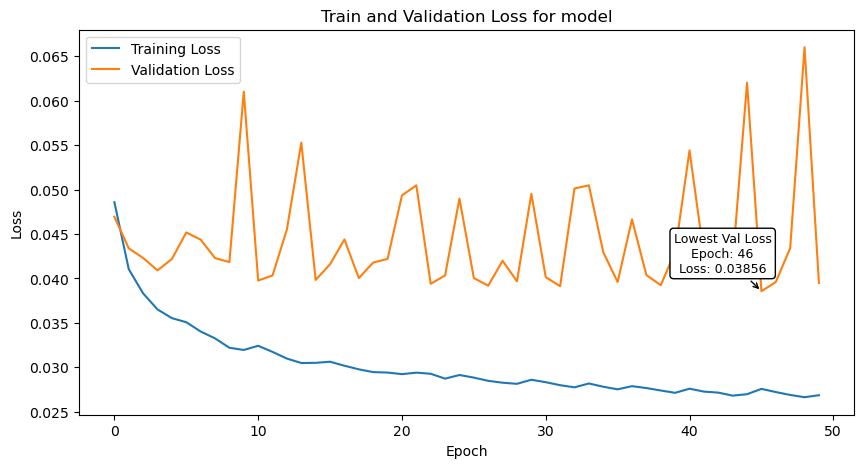

In [23]:
plot_train_val_loss(model_results, 'model', image_dir_path=image_dir_path)